CAT-Seg
====

**CAT-Seg: Cost Aggregation for Open-Vocabulary Semantic Segmentation**

 * Paper: https://arxiv.org/abs/2303.11797

![CAT-Seg Overview](../assets/catseg_overview.jpg)

## Installation

```bash
conda create -n catseg python=3.8 -y
conda activate catseg

conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 \
    pytorch-cuda=11.7 -c pytorch -c nvidia


# install detectron2:
python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# install open-clip
pip install open-clip-torch

# other requirements:
pip install -r requirements.txt
```


### Other setup
```bash
ln -s CATSeg_repo/datasets/ .
```

## Download model
```bash
wget https://huggingface.co/spaces/hamacojr/CAT-Seg-weights/resolve/main/model_base.pth
```

In [1]:
import os
import sys
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.engine.defaults import DefaultPredictor

# Import CAT-Seg's configuration helper
# Make sure the CAT-Seg repository root is in your PYTHONPATH
sys.path.append("CATSeg_repo")
from cat_seg import add_cat_seg_config
from demo.predictor import VisualizationDemo  # optional for overlay


def setup_cfg(
        config_file: str,
        weights: str,
        class_json: str = None,
        device: str = None
    ):
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_cat_seg_config(cfg)
    cfg.merge_from_file(config_file)

    # Override the weights and device
    cfg.MODEL.WEIGHTS = weights

    if class_json:
        # Override class JSON paths for zero-shot classification
        cfg.MODEL.SEM_SEG_HEAD.TRAIN_CLASS_JSON = class_json
        cfg.MODEL.SEM_SEG_HEAD.TEST_CLASS_JSON = class_json

    # Set the computation device
    if device is not None:
        cfg.MODEL.DEVICE = device
    else:
        cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    cfg.freeze()
    return cfg


def run_inference(
        predictor: DefaultPredictor,
        image: np.ndarray
    ):
    # Run the model
    predictions = predictor(image)

    # Extract semantic segmentation mask if available
    sem_seg_mask = None
    if "sem_seg" in predictions:
        # ``predictions['sem_seg']`` is a tensor of shape (num_classes, H, W)
        sem_seg = predictions["sem_seg"]
        # Convert to numpy array of class indices (H, W)
        sem_seg_mask = sem_seg.argmax(dim=0).to(torch.int32).cpu().numpy()

    return predictions, sem_seg_mask


/home/pyml/anaconda3/envs/catseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = setup_cfg(
    config_file="CATSeg_repo/configs/vitb_384.yaml",
    weights="./model_base.pth",
    class_json=None, #"./class.json",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# Create the predictor
predictor = DefaultPredictor(cfg)

predictor

/home/pyml/anaconda3/envs/catseg/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


(1137, 1068, 3)
dict_keys(['sem_seg'])


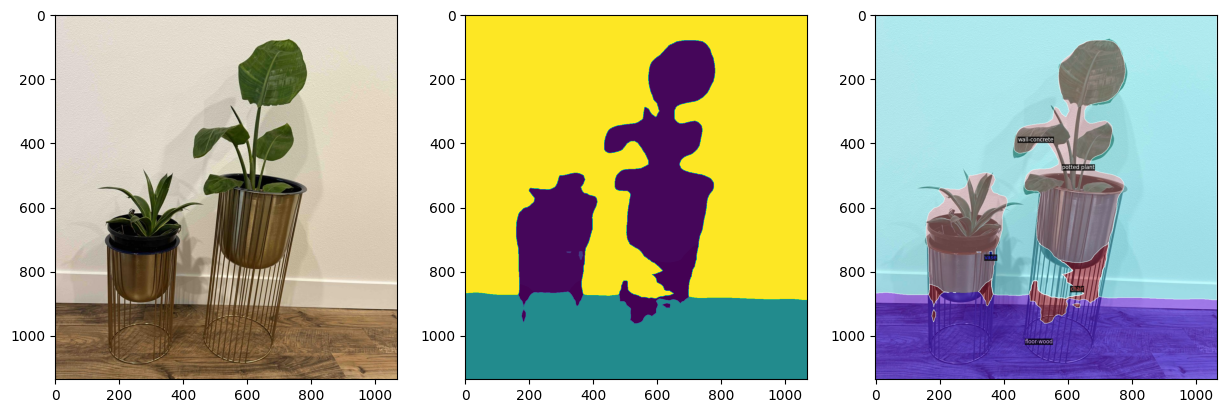

In [4]:
image_path = "../samples/plants.jpg"
# Read image in BGR order as expected by Detectron2
image_np = cv2.imread(image_path, cv2.IMREAD_COLOR)
print(image_np.shape)

res = run_inference(predictor, image_np)
print(res[0].keys())

demo = VisualizationDemo(cfg)
_, vis_output = demo.run_on_image(image_np)
# Convert the output (VisImage) to BGR for OpenCV saving
overlay_img = vis_output.get_image()[:, :, ::-1]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
axes[0].imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
axes[1].imshow(res[0]["sem_seg"].cpu().numpy().argmax(0))
axes[2].imshow(overlay_img)
plt.show()